In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harinirajm0han","key":"100c1efc22c35b615f535c36d208cc3e"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d skooch/ddsm-mammography

Dataset URL: https://www.kaggle.com/datasets/skooch/ddsm-mammography
License(s): CC0-1.0
100% 2.88G/2.88G [02:23<00:00, 23.9MB/s]
100% 2.88G/2.88G [02:23<00:00, 21.6MB/s]


In [ ]:
!unzip ddsm-mammography.zip -d /content/ddsm_dataset

Archive:  ddsm-mammography.zip
  inflating: /content/ddsm_dataset/cv10_data/cv10_data.npy  
  inflating: /content/ddsm_dataset/cv10_labels.npy  
  inflating: /content/ddsm_dataset/test10_data/test10_data.npy  
  inflating: /content/ddsm_dataset/test10_labels.npy  
  inflating: /content/ddsm_dataset/training10_0/training10_0.tfrecords  
  inflating: /content/ddsm_dataset/training10_1/training10_1.tfrecords  
  inflating: /content/ddsm_dataset/training10_2/training10_2.tfrecords  
  inflating: /content/ddsm_dataset/training10_3/training10_3.tfrecords  
  inflating: /content/ddsm_dataset/training10_4/training10_4.tfrecords  


In [ ]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import tensorflow as tf
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [ ]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [ ]:
import os

filenames = []
base_path = "/content/ddsm_dataset"

# Iterate over each subdirectory and collect file paths
for folder in ["training10_0", "training10_1", "training10_2", "training10_3", "training10_4"]:
    folder_path = os.path.join(base_path, folder)

    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Get all files inside the directory
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            filenames.append(file_path)

# Now pass only valid file paths to read_data()
for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))


Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None

In [ ]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)

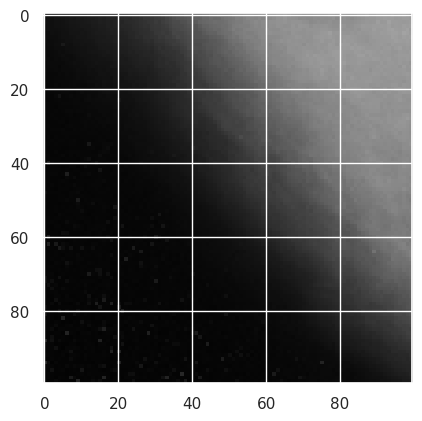

In [ ]:
plt.imshow(x_train[0])

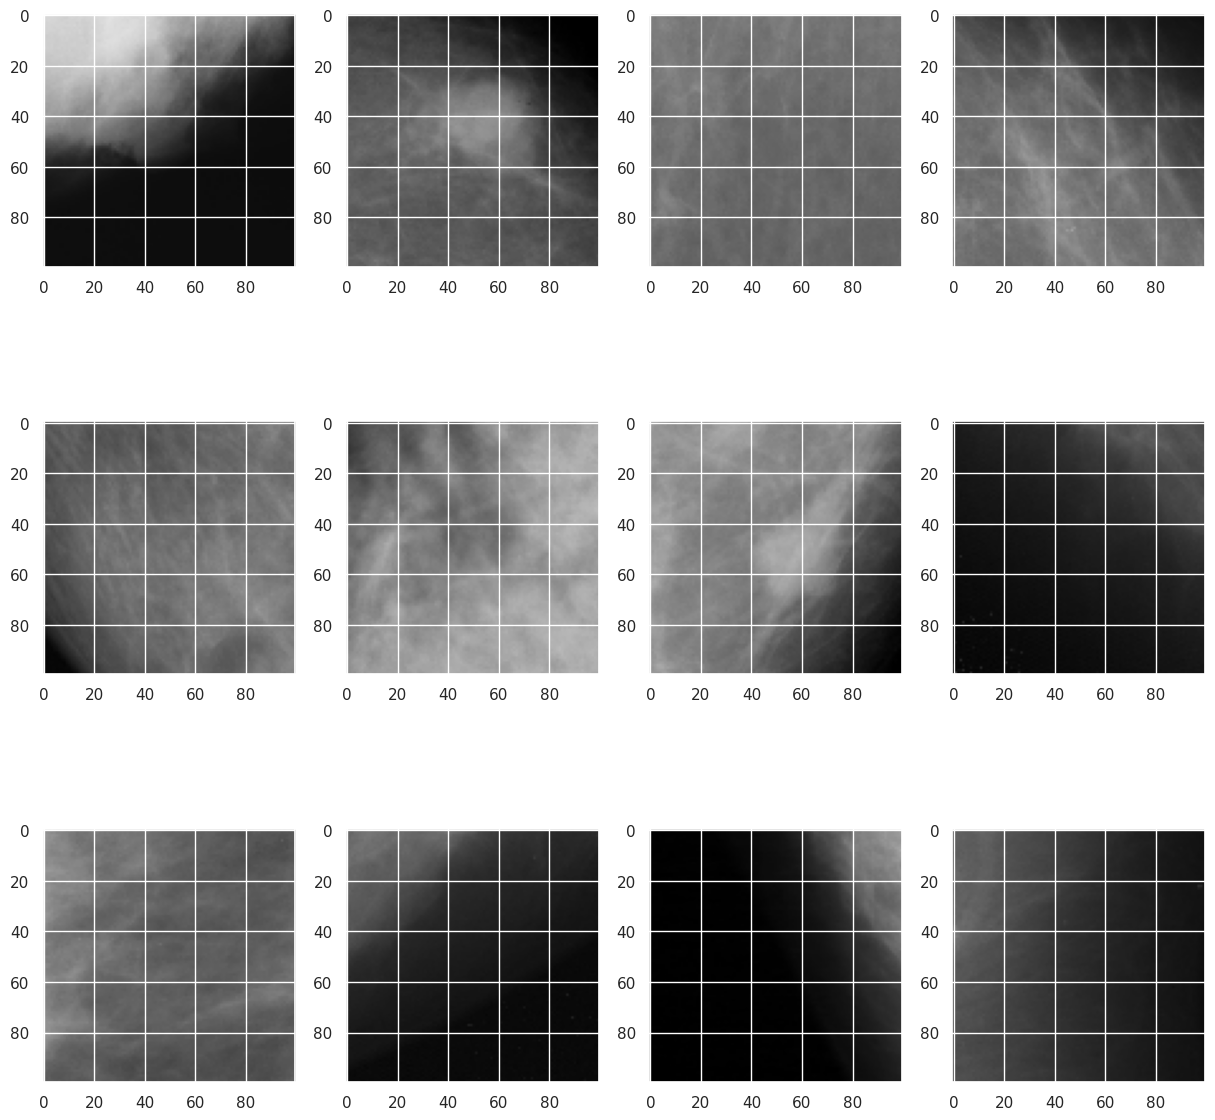

In [ ]:
fig=plt.figure(figsize=(15,15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[i])
plt.show()

Alexnet


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

print(x_train[0].shape)

(100, 100, 3)


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Define AlexNet model
def create_alexnet():
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'))

    # Fourth Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation='relu'))

    # Fifth Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))  # Binary Classification

    return model

# Create the model
alexnet_sgd = create_alexnet()

# Compile with SGD optimizer
alexnet_sgd.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
alexnet_sgd.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

Alexnet+SGD


In [ ]:
history = alexnet_sgd.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.8630 - loss: 0.5501 - val_accuracy: 0.8907 - val_loss: 0.3459
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8854 - loss: 0.3524 - val_accuracy: 0.8850 - val_loss: 0.3514
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8905 - loss: 0.3311 - val_accuracy: 0.8958 - val_loss: 0.3062
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8922 - loss: 0.3222 - val_accuracy: 0.9042 - val_loss: 0.2848
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8944 - loss: 0.3036 - val_accuracy: 0.8929 - val_loss: 0.2873
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8979 - loss: 0.2842 - val_accuracy: 0.8661 - val_loss: 0.3217
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8991 - loss: 0.2750 - val_accuracy: 0.9085 - val_loss: 0.2491
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9033 - loss: 0.2618 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_sgd.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9130 - loss: 0.2303
Test Loss: 0.2301
Test Accuracy: 0.9121


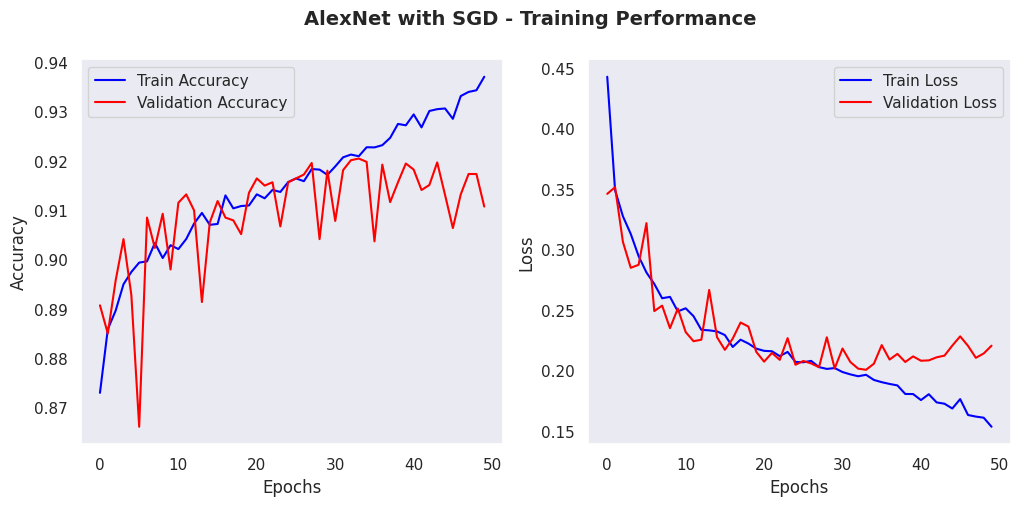

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with SGD - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


Alexnet+Adam


In [ ]:
from tensorflow.keras.optimizers import Adam

# Create the model
alexnet_adam = create_alexnet()

# Compile with Adam optimizer
alexnet_adam.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print model summary
alexnet_adam.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = alexnet_adam.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8555 - loss: 3.9997 - val_accuracy: 0.8781 - val_loss: 0.2909
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8835 - loss: 0.2787 - val_accuracy: 0.8705 - val_loss: 0.2832
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8876 - loss: 0.2659 - val_accuracy: 0.8913 - val_loss: 0.2466
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8953 - loss: 0.2573 - val_accuracy: 0.8844 - val_loss: 0.2747
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8951 - loss: 0.2647 - val_accuracy: 0.9085 - val_loss: 0.2380
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.8987 - loss: 0.2494 - val_accuracy: 0.9040 - val_loss: 0.2459
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9037 - loss: 0.2394 - val_accuracy: 0.9092 - val_loss: 0.2303
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9064 - loss: 0.2321 - 

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_adam.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8732 - loss: 0.3806
Test Loss: 0.3878
Test Accuracy: 0.8696


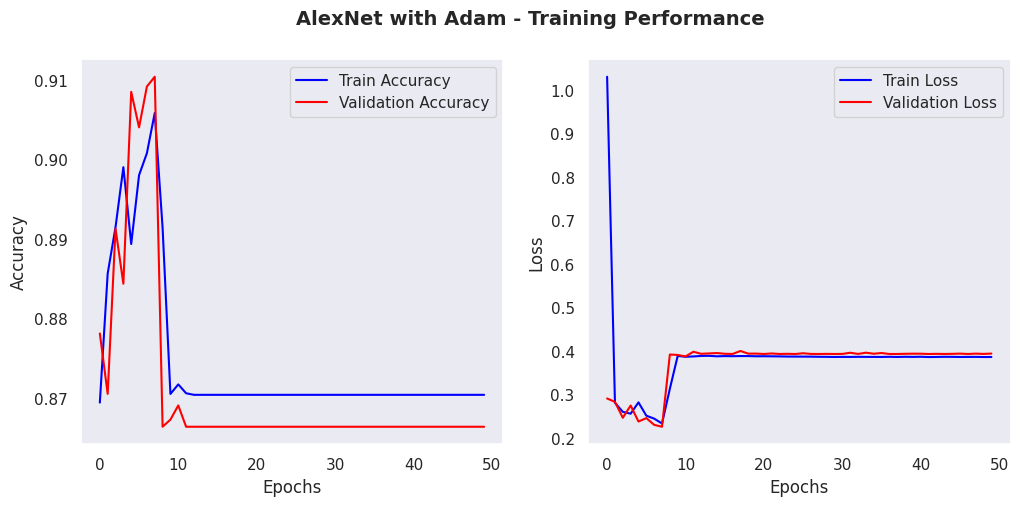

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with Adam - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


Alexnet+RMSProp


In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Create the model
alexnet_rmsprop = create_alexnet()

# Compile with RMSprop optimizer
alexnet_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Print model summary
alexnet_rmsprop.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 23, 23, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 5, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 5, 5, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,731,009 (94.34 MB)

 Trainable params: 24,731,009 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = alexnet_rmsprop.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.8250 - loss: 1534.8746 - val_accuracy: 0.8664 - val_loss: 0.3940
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8676 - loss: 0.5450 - val_accuracy: 0.8664 - val_loss: 0.4111
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8687 - loss: 0.4851 - val_accuracy: 0.8664 - val_loss: 0.3602
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8711 - loss: 0.3977 - val_accuracy: 0.8664 - val_loss: 0.3812
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8702 - loss: 0.4085 - val_accuracy: 0.8661 - val_loss: 0.3370
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8732 - loss: 0.3382 - val_accuracy: 0.8783 - val_loss: 0.3594
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8874 - loss: 0.2996 - val_accuracy: 0.8932 - val_loss: 0.2446
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8971 - loss: 0.2659

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = alexnet_rmsprop.evaluate(x_test, y_test, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9073 - loss: 0.2327
Test Loss: 0.2353
Test Accuracy: 0.9059


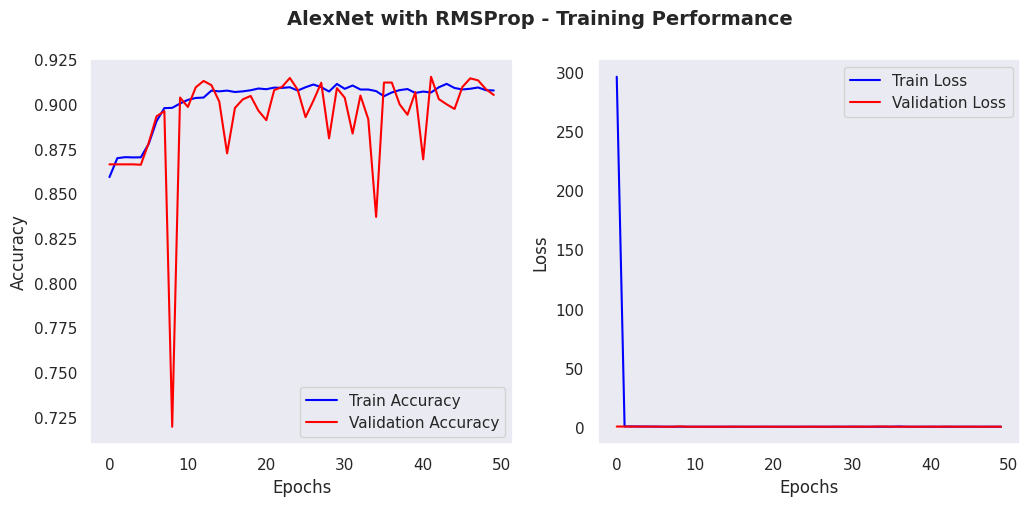

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Single title for both subplots
plt.suptitle("AlexNet with RMSProp - Training Performance", fontsize=14, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.show()


Densenet121


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

print(x_train[0].shape)

# Use correct weights or initialize randomly
base_model = DenseNet121(input_shape=(100,100,3), weights=None, include_top=False)



model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()


(100, 100, 3)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 3, 3, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 9216)                │          36,864 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1024)                │              

 Total params: 19,678,785 (75.07 MB)

 Trainable params: 12,614,657 (48.12 MB)

 Non-trainable params: 7,064,128 (26.95 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [ ]:
from tensorflow.keras.optimizers import SGD

# Define SGD with learning rate and momentum
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)


model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    shuffle=True,
    epochs=50,
    batch_size=128
)


Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 87s 203ms/step - accuracy: 0.9058 - loss: 0.2210 - val_accuracy: 0.9084 - val_loss: 0.2097
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.9088 - loss: 0.2140 - val_accuracy: 0.9110 - val_loss: 0.2021
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9073 - loss: 0.2185 - val_accuracy: 0.9056 - val_loss: 0.2187
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9106 - loss: 0.2077 - val_accuracy: 0.9092 - val_loss: 0.2035
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9055 - loss: 0.2163 - val_accuracy: 0.9117 - val_loss: 0.2031
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9093 - loss: 0.2139 - val_accuracy: 0.9109 - val_loss: 0.2037
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.9082 - loss: 0.2157 - val_accuracy: 0.9089 - val_loss: 0.2083
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.9118 - loss: 0.2095 -

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9196 - loss: 0.2053
Test_loss_value = 0.20623838901519775
test_accuracy = 0.9157198071479797


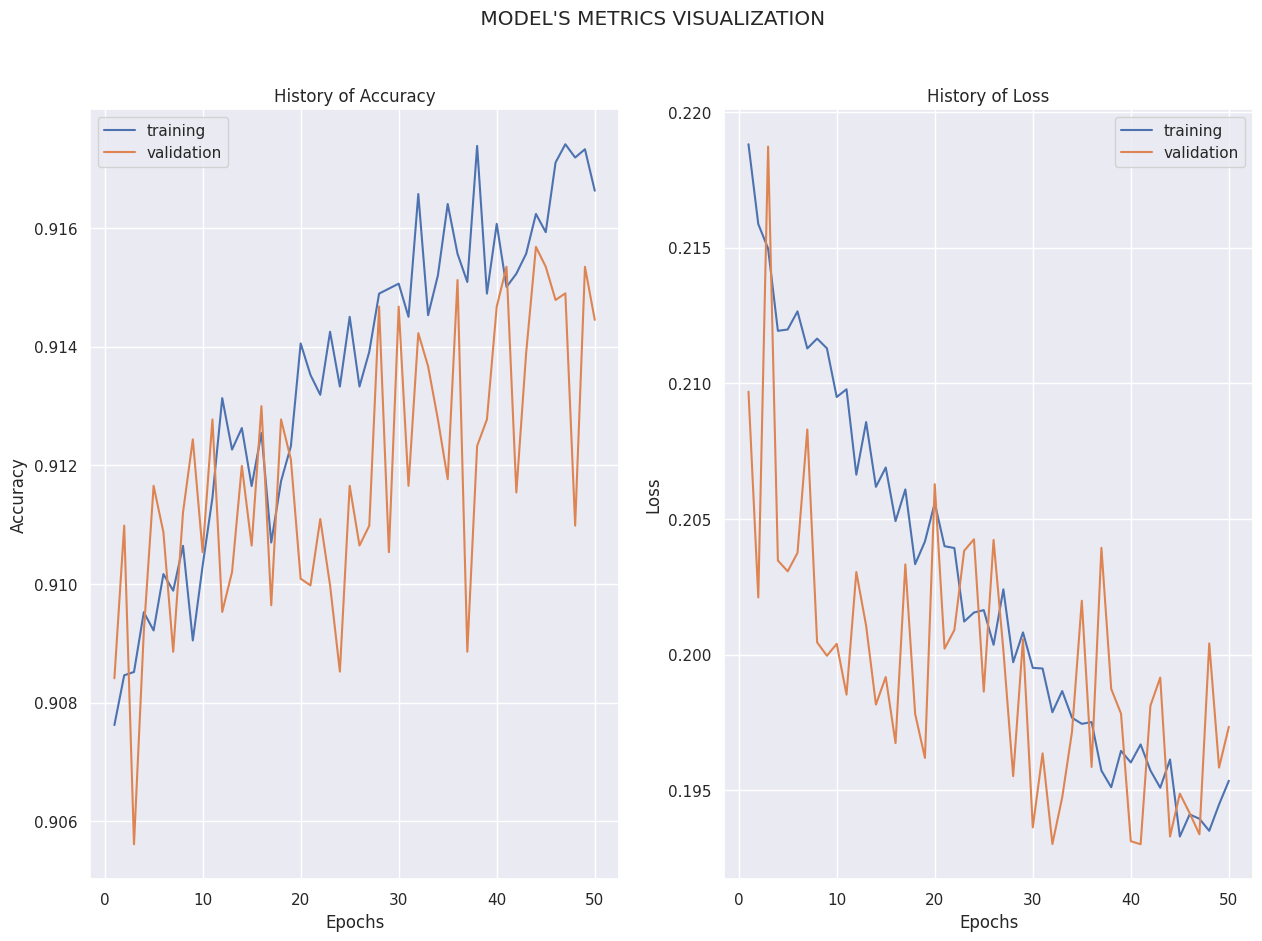

In [ ]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

ResNet50


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define ResNet50 base model
base_model = ResNet50(input_shape=(100, 100, 3), weights=None, include_top=False)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define custom model
model = Sequential([
    base_model,
    Dropout(0.2),
    Flatten(),
    BatchNormalization(),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Added a Dense layer with 1 unit and sigmoid activation for binary classification
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1024)                │              

 Total params: 60,440,449 (230.56 MB)

 Trainable params: 36,779,009 (140.30 MB)

 Non-trainable params: 23,661,440 (90.26 MB)

In [ ]:
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 20 epochs without callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,  # 20% of data for validation
    shuffle=True,          # Shuffle data during training
    epochs=50,             # Set the number of epochs
    batch_size=128,        # Set batch size
    verbose=1              # Display training progress
)




Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 72s 194ms/step - accuracy: 0.8854 - loss: 0.2893 - val_accuracy: 0.8862 - val_loss: 0.2552
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.8942 - loss: 0.2574 - val_accuracy: 0.8981 - val_loss: 0.2467
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9001 - loss: 0.2417 - val_accuracy: 0.9036 - val_loss: 0.2309
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - accuracy: 0.9038 - loss: 0.2331 - val_accuracy: 0.9080 - val_loss: 0.2218
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.9089 - loss: 0.2221 - val_accuracy: 0.8953 - val_loss: 0.2304
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.9108 - loss: 0.2167 - val_accuracy: 0.8969 - val_loss: 0.2310
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step - accuracy: 0.9099 - loss: 0.2166 - val_accuracy: 0.9086 - val_loss: 0.2211
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.9140 - loss: 0

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))


350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9161 - loss: 0.2191
Test_loss_value = 0.22622093558311462
test_accuracy = 0.9158987402915955


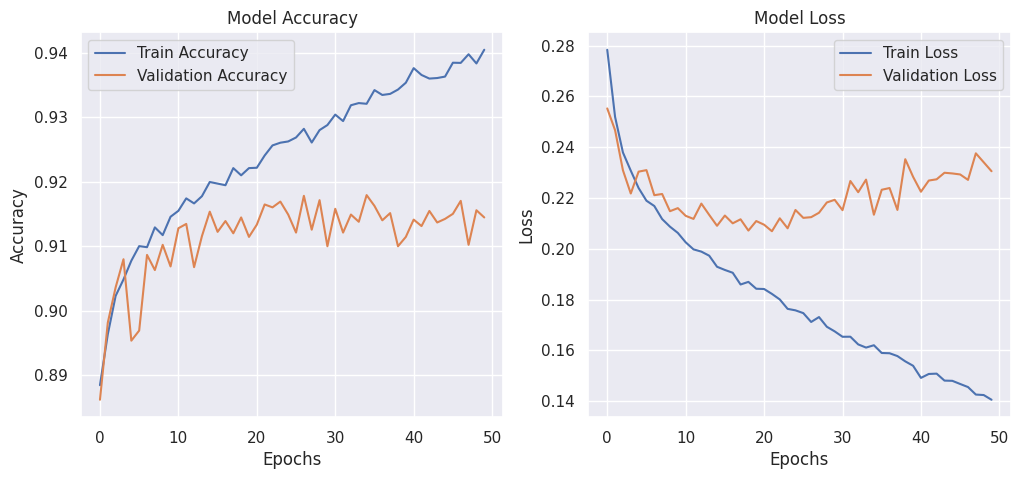

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
# Check input shape (adjust based on your dataset)
print(x_train[0].shape)

# Load the EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

# Freeze base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Build Model
model = Sequential([
    base_model,
    Dropout(0.2),
    Flatten(),
    BatchNormalization(),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Print Model Summary
model.summary()


(100, 100, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20480)               │          81,920 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      20,972,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,216,548 (103.82 MB)

 Trainable params: 23,119,873 (88.20 MB)

 Non-trainable params: 4,096,675 (15.63 MB)

In [ ]:
# Import Adam optimizer
from tensorflow.keras.optimizers import Adam

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 71s 144ms/step - accuracy: 0.8162 - loss: 0.3941 - val_accuracy: 0.9197 - val_loss: 0.2051
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9164 - loss: 0.2060 - val_accuracy: 0.9237 - val_loss: 0.1865
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.9264 - loss: 0.1853 - val_accuracy: 0.9299 - val_loss: 0.1785
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9343 - loss: 0.1650 - val_accuracy: 0.9293 - val_loss: 0.1727
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9375 - loss: 0.1544 - val_accuracy: 0.9319 - val_loss: 0.1704
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9418 - loss: 0.1510 - val_accuracy: 0.9297 - val_loss: 0.1786
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.9449 - loss: 0.1391 - val_accuracy: 0.9303 - val_loss: 0.1836
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9474 - loss: 0.1348 -

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9374 - loss: 0.2454
Test_loss_value = 0.26497992873191833
test_accuracy = 0.9332557916641235


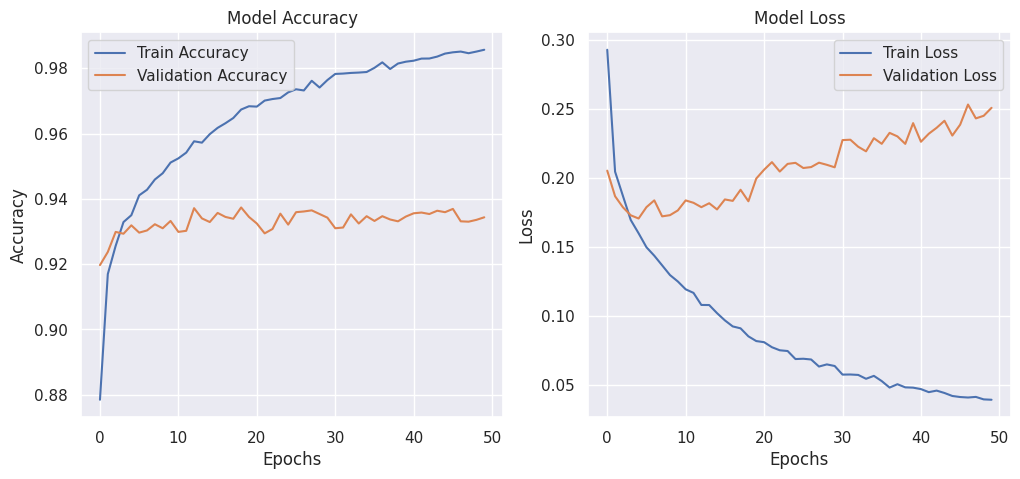

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Classifier-Random Forest Classifier


In [ ]:
#Defining our ANN Model
ann_model=Sequential()
ann_model.add(Dense(8, input_dim=128, kernel_initializer = 'uniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'HeUniform', activation = 'relu'))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(64, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(32, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu' ))
#ann_model.add(BatchNormalization())
#ann_model.add(Dropout( 0.2))
ann_model.add(Dense(1,activation='sigmoid'))
ann_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,457 (25.22 KB)

 Trainable params: 6,457 (25.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
names = [

        'SVM',
        "Random Forest Classifier",

         ]
classifiers = [

    SVC(),
    RandomForestClassifier(),

        ]
zipped_clf = zip(names,classifiers)

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

def classifier_summary(pipeline, X_train, y_train, X_val, y_val,X_test,y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train= sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train),4)*100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'),4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'),4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'),4)
    train_kappa =  np.round(cohen_kappa_score(y_train, y_pred_train),4)


    val_accuracy = np.round(accuracy_score(y_val, y_pred_val),4)*100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'),4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'),4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'),4)
    val_kappa =  np.round(cohen_kappa_score(y_val, y_pred_val),4)


    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),2)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),2)



    print()
    print('------------------------ Train Set Metrics------------------------')
    print()
    print("Accuracy core : {}%".format(train_accuracy))
    cm=confusion_matrix(y_train,y_pred_train)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Validation Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(val_accuracy))
    cm=confusion_matrix(y_val,y_pred_val)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

    print('------------------------ Test Set Metrics------------------------')
    print()
    print("Accuracy score : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Kappa Score : {} ".format(test_kappa))
    print("Recall score: {}".format(test_recall))
    print("Precision score : {}".format(test_precision))
    cm=confusion_matrix(y_test,y_pred_test)
    cm_plot=plot_confusion_matrix(cm,classes=['0','1'])


    print("-"*80)
    print()

In [ ]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('Classifier', c)])
        print("------------------------------Fitting {} on input_data-------------------------------- ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2021, shuffle=True, stratify=y_train)

In [ ]:
base_model= VGG19(input_shape=(100,100,3), weights='imagenet', include_top=False)
x = base_model.output
# x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
# x = Dense(16,kernel_initializer='he_uniform')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(128, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
val_features=model_feat.predict(x_val)
test_features=model_feat.predict(x_test)

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 72s 64ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

------------------------------Fitting Random Forest Classifier on input_data-------------------------------- 

------------------------ Train Set Metrics------------------------

Accuracy core : 100.0%
Confusion matrix, without normalization
[[31101     0]
 [    1  4664]]


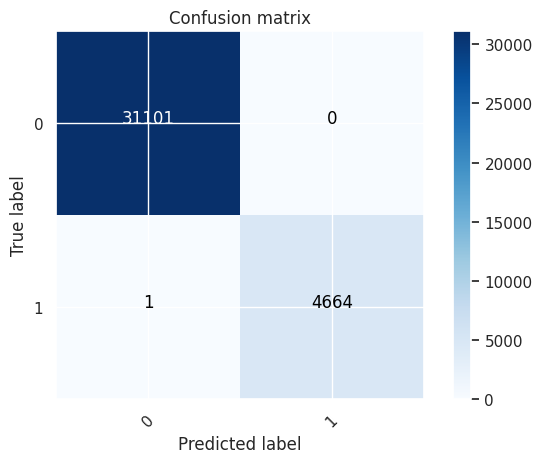

------------------------ Validation Set Metrics------------------------

Accuracy score : 88.38000000000001%
Confusion matrix, without normalization
[[7721   55]
 [ 984  182]]


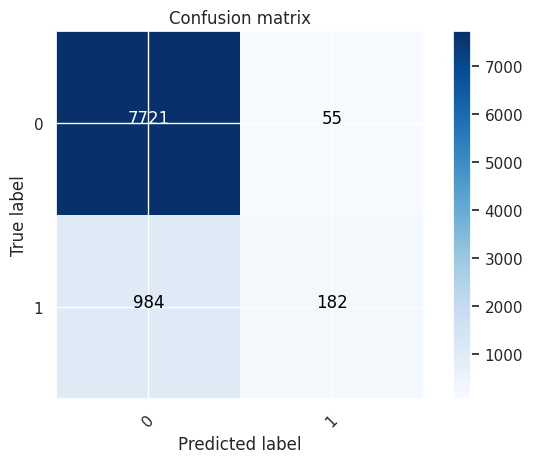

------------------------ Test Set Metrics------------------------

Accuracy score : 88.14999999999999%
F1_score : 0.85
Kappa Score : 0.22 
Recall score: 0.88
Precision score : 0.86
Confusion matrix, without normalization
[[9622   97]
 [1228  230]]


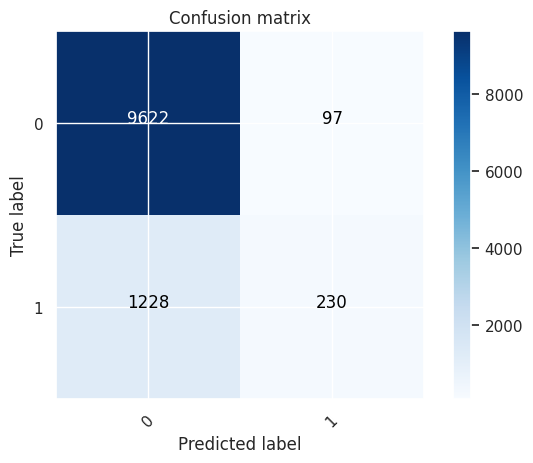

--------------------------------------------------------------------------------



In [ ]:
classifier_comparator(train_features,y_train,val_features,y_val,test_features,y_test,classifier=zipped_clf)